<a href="https://colab.research.google.com/github/akshaygrao77/DeepLearning-Assignment2/blob/main/PART_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > dataset.zip

In [2]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [3]:
#Import and install required libraries
import os
import glob
import tensorflow as tf

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.callbacks import History
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
!pip install wandb
!wandb login
import wandb
from wandb.keras import WandbCallback
import os
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import LeakyReLU
from keras.layers import PReLU
from keras.initializers import Constant

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 144 kB 42.5 MB/s 
     |████████████████████████████████| 181 kB 42.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6db1a05b358a421d647acf93c453ede728d68f6cd1fb1b3357d874fb48a47b4d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
path_train_data = os.getcwd()+"/inaturalist_12K/train"
path_test_data = os.getcwd()+"/inaturalist_12K/val"

width, height = 200, 200

batch_size = 128

In [5]:
 wandb.init(project="DLAssignment2", entity='cs21s002-ee21s113-dlassignment-1')
 #wandb.init(project="DeepLearningAssignment2-parta", entity='akshaygrao')

wandb: Currently logged in as: manu_data_analyst (use `wandb login --relogin` to force relogin)


In [6]:
def get_model(filter_list=[64, 32, 48, 32, 32], dropout=0.2, batch_norm=False, dense_layer_size=512, conv_activations=["relu", "relu", "relu", "relu", "relu"], dense_layer_activation="relu", output_activation="softmax"):
    
    model = Sequential()

    for i in range(5):
        model.add(Conv2D(filter_list[i], (5, 5), input_shape=(200,200,3), padding="same"))
        if batch_norm:
            model.add(BatchNormalization())
        if(conv_activations[i] == 'leakyrelu'):
          model.add(LeakyReLU())
        elif(conv_activations[i] == 'prelu'):
          model.add(PReLU(alpha_initializer=Constant(value=0.25)))
        else:
          model.add(Activation(conv_activations[i]))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_layer_size))
    model.add(Dropout(dropout))
    if(dense_layer_activation == 'leakyrelu'):
      model.add(LeakyReLU())
    elif(dense_layer_activation == 'prelu'):
      model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    else:
      model.add(Activation(dense_layer_activation))
    model.add(Dense(10))
    model.add(Activation(output_activation))

    return model;

In [7]:
def get_dataset_generators(train_data_aug=False):
    if train_data_aug:
        train_idg = ImageDataGenerator(
            rescale=1. /255,
            validation_split=0.1,               #10% is to be kept aside
            horizontal_flip=True,
            vertical_flip=False,
            rotation_range=15,
            shear_range=0.1,
            zoom_range=0.1,
            width_shift_range=0.2,
            height_shift_range=0.2
        )
    else:
        train_idg = ImageDataGenerator(
            rescale=1. /255,
            validation_split=0.1                 #10% is to be kept aside
        )
    
    test_idg = ImageDataGenerator(
            rescale=1. /255
        )
    
    print(f"{path_train_data}")
    train_generator = train_idg.flow_from_directory(
        path_train_data,
        batch_size=batch_size,
        target_size=(width, height),
        subset='training',
        class_mode='categorical'
    )

    val_generator = train_idg.flow_from_directory(
        path_train_data,
        batch_size=batch_size,
        target_size=(width, height),
        subset='validation',
        class_mode='categorical'
    )

    print(f"{path_test_data}")
    test_generator = test_idg.flow_from_directory(
        path_test_data,
        batch_size=batch_size, 
        target_size=(width, height)
    )
    
    return train_generator, val_generator, test_generator

In [8]:
default_config = {
        "filter_list":[64, 32, 48, 32, 32], 
        "dropout":0.2, 
        "batch_norm":False, 
        "dense_layer_size":512,
        "epochs": 10,
        "lr": 0.001,
        "train_data_aug":False,
        "activations": "relu"
    }

#Keras callback    
history = History()

In [9]:
def run():
    # Create a MirroredStrategy.
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
    else:  # use default strategy
        strategy = tf.distribute.get_strategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    # wandb.init(config=default_config, magic=True, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')
    wandb.init(config=default_config, magic=True, project='DeepLearningAssignment2-parta', entity='akshaygrao')
    config = wandb.config
    print("Config: "+str(config))
    run_name = str(config).replace("{", "").replace("}","").replace(":","-")
    wandb.run.name = run_name

    # Open a strategy scope and create the model
    with strategy.scope():
      acts = [config.activations] * 5
      model = get_model(config.filter_list, config.dropout, config.batch_norm, config.dense_layer_size,dense_layer_activation=config.activations,conv_activations=acts)

    plot_model(model)

    model.summary()

    train_generator, val_generator, test_generator = get_dataset_generators(config.train_data_aug)

    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(config.lr), metrics="categorical_accuracy")

    model.fit(train_generator, epochs=config.epochs, validation_data=val_generator, callbacks=[WandbCallback(), history])

    model.evaluate(test_generator)

    model.save(f'{run_name.replace(",","-")}.h5')  # creates a HDF5 file 'my_model.h5'

In [10]:
sweep_config = {
    "name": "Assignment 2 - alpha -act-changing",
    "method": "bayes",
    "metric":{
      "goal": "maximize",
      "name": "val_categorical_accuracy"
    },
    "early_terminate":{
      "type": "hyperband",
      "min_iter": 2,
      "eta":2
    },
    "project": 'Assignment 2',
    "parameters": {
        "filter_list": {
            "values": [[64,128,350,256,128]]
        },
        "dropout": {
            "values": [0.5,0.7,0.6]
        },
        "batch_norm": {
            "values": [True,False]
        },
        "dense_layer_size": {
            "values": [5096]
        },
        "train_data_aug": {
            "values": [True,False]
        },
        "epochs": {
            "values": [8]
        },
        "lr": {
            "values": [0.0001]
        },
        "activations": {
            "values":[ 'leakyrelu','prelu']
        }
        
    }
}

In [11]:
# sweep_id = wandb.sweep(sweep_config, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')
# sweep_id = wandb.sweep(sweep_config,  project='DeepLearningAssignment2-parta', entity='akshaygrao')

In [12]:
# wandb.agent(sweep_id, function=run, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')
# wandb.agent(sweep_id, function=run, project='DeepLearningAssignment2-parta', entity='akshaygrao')

In [13]:
sweep_config_v2 = {
    "name": "Assignment 2 - test",
    "metric": "categorical_accuracy",
    "method": "random",
    "project": 'Assignment 2',
    "parameters": {
        "filter_list": {
            "values": [[64, 64, 64, 64, 64]]
        },
        "dropout": {
            "values": [0.2, 0.3, 0.5]
        },
        "batch_norm": {
            "values": [False]
        },
        "dense_layer_size": {
            "values": [512]
        },
        "train_data_aug": {
            "values": [True]
        },
        "epochs": {
            "values": [7,10]
        },
        "lr": {
            "values": [0.001, 0.0001]
        },
        
    }
}

In [14]:
def test():
    # Create a MirroredStrategy.
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
    else:  # use default strategy
        strategy = tf.distribute.get_strategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    # wandb.init(config=default_config, magic=True, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')
    wandb.init(config=default_config, magic=True, project='DeepLearningAssignment2-parta', entity='akshaygrao')
    config = wandb.config
    run_name = str(config).replace("{", "").replace("}","").replace(":","-")
    wandb.run.name = run_name

    # Open a strategy scope and create the model
    with strategy.scope():
        model = get_model(config.filter_list, config.dropout, config.batch_norm, config.dense_layer_size)

    plot_model(model, to_file="temp.png")

    model.summary()

    train_generator, val_generator, test_generator = get_dataset_generators(config.train_data_aug)

    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(config.lr), metrics="categorical_accuracy")

    model.fit(train_generator, epochs=config.epochs, validation_data=test_generator, callbacks=[WandbCallback()])

In [15]:
#sweep_id = wandb.sweep(sweep_config_v2, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')

In [16]:
#wandb.agent(sweep_id, function=test, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')

In [17]:
# Create a MirroredStrategy.
if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
else:  # use default strategy
    strategy = tf.distribute.get_strategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope and create the model
with strategy.scope():
    model = get_model(filter_list=[64,128,256,256,128], dropout = 0.7, batch_norm = False, dense_layer_size= 4096,conv_activations=['leakyrelu','leakyrelu','leakyrelu','leakyrelu','leakyrelu'],dense_layer_activation='leakyrelu')

plot_model(model)

model.summary()

train_generator, val_generator, test_generator = get_dataset_generators(False)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(0.0001), metrics="accuracy")

model.fit(train_generator, epochs=8, validation_data=val_generator, callbacks=[history])

model.evaluate(test_generator)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 200, 200, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100, 100, 128)     0         
                                                                 

[1.8184363842010498, 0.3695000112056732]

In [18]:
classes = {0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}

images, labels = test_generator.next()
predictions = model(images)

In [40]:
count = [0]*10
images_list = []
f, a = plt.subplots(nrows=10, ncols=3, figsize=(15,50))
columns=["id", "image", "Predictions"]
wandb.Table.MAX_ROWS = 20
test_table = wandb.Table(columns=columns)
for i, img in enumerate(images):
    class_label = np.argmax(labels[i], axis=0)
    pred_label = np.argmax(predictions[i], axis=0)
    if count[class_label] < 3:
        a[class_label, count[class_label]].imshow(img)
        a[class_label, count[class_label]].axis('off')
        ttl = "Actual: " + classes[class_label] + "\nPredicted: " + classes[pred_label]
        a[class_label, count[class_label]].set_title(ttl)
        count[class_label] += 1
        images_list.append((img, ttl))
        test_table.add_data(i,wandb.Image(img),ttl)
        wandb.log({"Prediction Grid Table":test_table}) 

        
plt.show()

(1, 200, 200, 64)


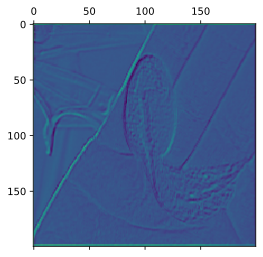

In [20]:
layer_outputs = [layer.output for layer in model.layers]

activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(images[55:56])
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 63])

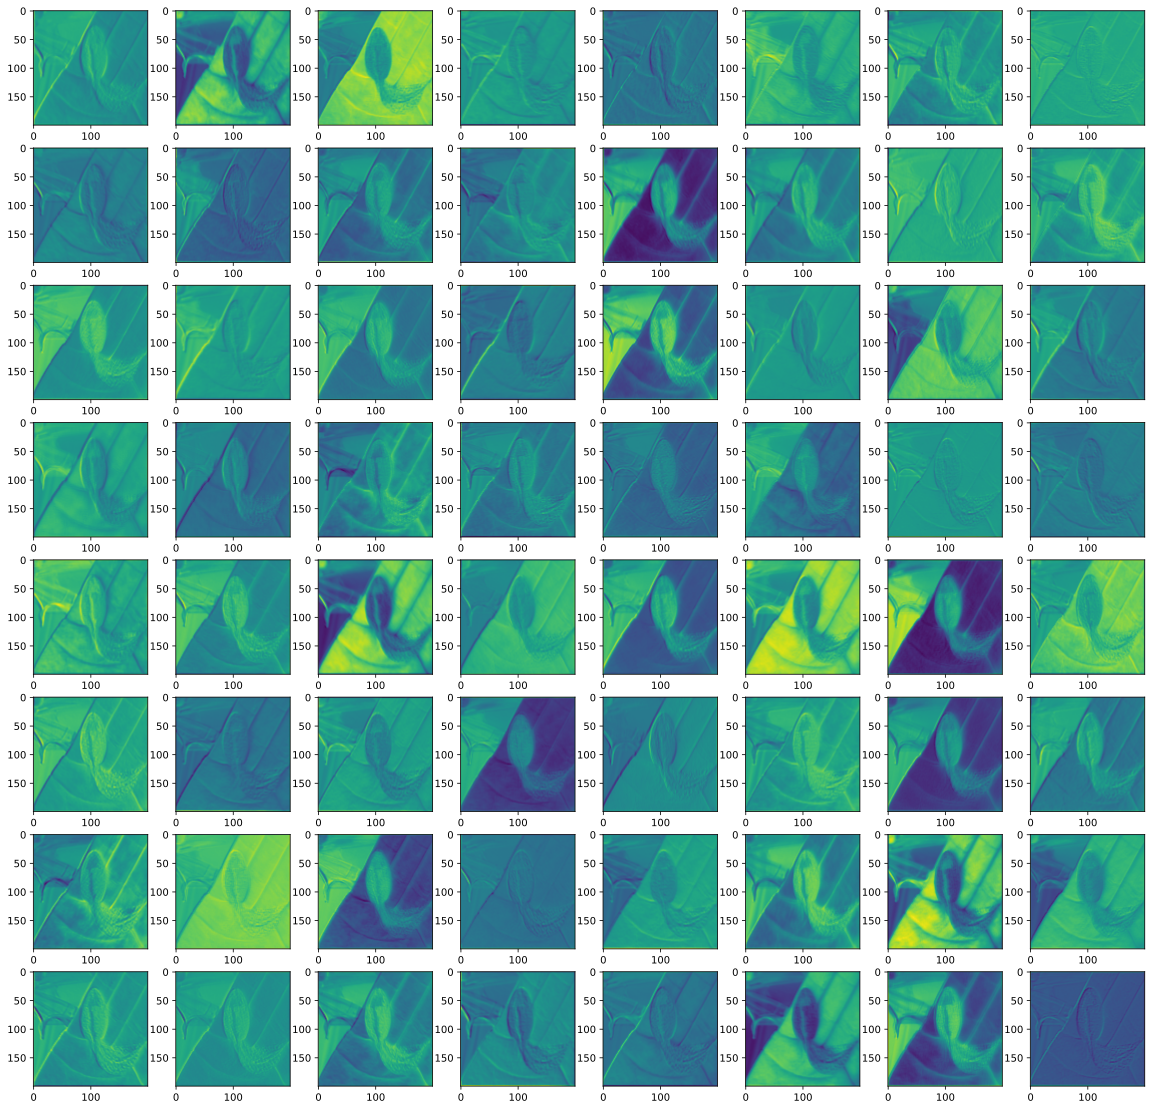

In [21]:
plt.figure(figsize=(20,40))
for d in range(64):
  plt.subplot(16, 8, d+1)
  plt.imshow(first_layer_activation[0, :, :, d])
  wandb.log({"Filters": wandb.Image(first_layer_activation[0, :, :, d])})
  plt.savefig("filters.png")
plt.show()

In [22]:
filters_img = Image.open("filters.png") 
wandb.log({"Filters of Layer 1": wandb.Image(filters_img)})

In [23]:
model_upto_conv5 = tf.keras.models.Model([model.inputs],[model.get_layer("conv2d_4").output]) 
@tf.custom_gradient
def guidedRelU(x):
    def grad(dy):
        return tf.cast(dy>0, tf.float32) * tf.cast(x>0, tf.float32) * dy
    return tf.nn.relu(x), grad

for layer in model.layers[1:]:
    if hasattr(layer, 'activation') and layer.activation==tf.keras.activations.relu:
        layer.activation = guidedRelU

f, a = plt.subplots(10, 2, figsize=(10, 40))
inputs = tf.convert_to_tensor(images[55:65], dtype=tf.float32)

for i in range(10):

    with tf.GradientTape() as tape:
        input = tf.expand_dims(inputs[i], 0)
        tape.watch(input)
        output = model_upto_conv5(input)[0]
    
    gradients = tape.gradient(output,input)[0]

    a[i][0].set_title("Original")
    a[i][0].imshow(inputs[i])
    a[i][1].set_title("Guided backpropagation")
    a[i][1].imshow(gradients)
wandb.log({"Guided Backpropagation": wandb.Image(f)})
f.savefig("guided_backprop.png")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i